In [153]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import networkx as nx
from __future__ import print_function
import os
import re
import tqdm
import string
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from tensorflow.keras.optimizers import SGD 
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import utils
from gensim.models import Doc2Vec
from sklearn.decomposition import TruncatedSVD
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

In [75]:
# Importar os datasets
df_txt = pd.read_csv("training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
df_var = pd.read_csv("training_variants")
test_var = pd.read_csv("test_variants")
test_txt = pd.read_csv("test_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])

In [4]:
# Visualizar o dataset com as variantes
df_var

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
...,...,...,...,...
3316,3316,RUNX1,D171N,4
3317,3317,RUNX1,A122*,1
3318,3318,RUNX1,Fusions,1
3319,3319,RUNX1,R80C,4


In [5]:
# Visualizar o dataset com os textos
df_txt

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...
...,...,...
3316,3316,Introduction Myelodysplastic syndromes (MDS) ...
3317,3317,Introduction Myelodysplastic syndromes (MDS) ...
3318,3318,The Runt-related transcription factor 1 gene (...
3319,3319,The RUNX1/AML1 gene is the most frequent targe...


In [6]:
# Concatenar os datasets com as variantes e o texto
train = pd.merge(df_var, df_txt, how='left', on='ID')
train

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...
...,...,...,...,...,...
3316,3316,RUNX1,D171N,4,Introduction Myelodysplastic syndromes (MDS) ...
3317,3317,RUNX1,A122*,1,Introduction Myelodysplastic syndromes (MDS) ...
3318,3318,RUNX1,Fusions,1,The Runt-related transcription factor 1 gene (...
3319,3319,RUNX1,R80C,4,The RUNX1/AML1 gene is the most frequent targe...


In [7]:
train.dtypes

ID            int64
Gene         object
Variation    object
Class         int64
Text         object
dtype: object

In [8]:
# Lista de variáveis categóricas
# Função para transformar a coluna em categórica
cat = ["Gene", "Class", "Variation"]
def transformar_coluna(df, lista_coluna, categoria):
    for i in lista_coluna:
        df[i] = df[i].astype(categoria)

transformar_coluna(train, cat, "category")
train

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...
...,...,...,...,...,...
3316,3316,RUNX1,D171N,4,Introduction Myelodysplastic syndromes (MDS) ...
3317,3317,RUNX1,A122*,1,Introduction Myelodysplastic syndromes (MDS) ...
3318,3318,RUNX1,Fusions,1,The Runt-related transcription factor 1 gene (...
3319,3319,RUNX1,R80C,4,The RUNX1/AML1 gene is the most frequent targe...


In [9]:
# Visualizar os tipos de variáveis
train.dtypes

ID              int64
Gene         category
Variation    category
Class        category
Text           object
dtype: object

In [10]:
# Checar se existem dados NA
""" 5 textos estão vazios"""
train.isna().sum()

ID           0
Gene         0
Variation    0
Class        0
Text         5
dtype: int64

In [11]:
# Descrever as variáveis categóricas
train.describe()

,ID
count,3321.000000
mean,1660.000000
std,958.834449
min,0.000000
25%,830.000000
50%,1660.000000
75%,2490.000000
max,3320.000000


In [12]:
# Observar os números das variáveis categóricas
""" 
- Existem 264 diferentes genes que foram avaliados (Maioria BRCA)
- Foram observadas 2996 diferentes variações (Maioria de mutações truncadas)
- Existem 9 diferentes classificações para os gentes e variações (Maioria foi class 7)
"""
for i in cat:
    print(train[i].value_counts())

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
         ... 
CTLA4       1
IKBKE       1
DUSP4       1
EIF1AX      1
KMT2B       1
Name: Gene, Length: 264, dtype: int64
7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64
Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
                        ..
H105R                    1
H1094L                   1
H1094R                   1
H1094Y                   1
p61BRAF                  1
Name: Variation, Length: 2996, dtype: int64


In [13]:
# Qual o gene que mais se repete
# O top 20 genes
top_gene = pd.DataFrame(train["Gene"].value_counts().nlargest(20).reset_index())
top_gene["Count"] = top_gene["Gene"]
top_gene["Gene"] = top_gene["index"]
top_gene = top_gene.drop("index", axis = 1)
top_gene

,Gene,Count
0,BRCA1,264
1,TP53,163
2,EGFR,141
3,PTEN,126
4,BRCA2,125
5,KIT,99
6,BRAF,93
7,ALK,69
8,ERBB2,69
9,PDGFRA,60


Text(0.5, 1.0, 'Top 20 Genes')

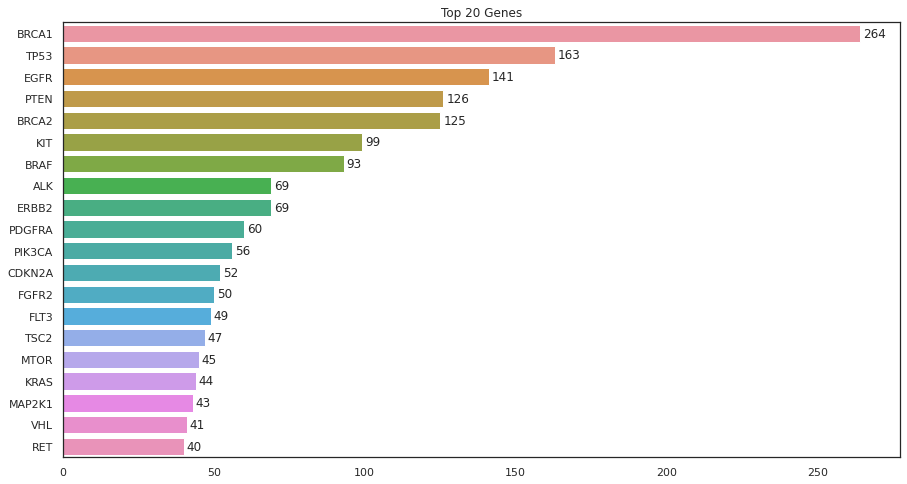

In [15]:
"""Maioria dos genes envolvidos nas mutações são os BRCA1"""
plt.figure(figsize=(15,8))
sns.set_theme(style="white", palette=sns.color_palette("Spectral"))
ax = sns.barplot(data=top_gene, x=top_gene.Count.to_list(), y=top_gene.Gene.to_list(), orient="h")
ax.bar_label(ax.containers[0], padding=3)
ax.set_title("Top 20 Genes")

In [16]:
# Qual a variação da mutação que mais se repete?
# O top 10 de variações
top_var = train.groupby("Variation")["ID"].agg("count").reset_index().rename(columns={"ID": "Count"}).sort_values("Count", ascending=False)
top_var[:10]

,Variation,Count
2629,Truncating Mutations,93
473,Deletion,74
149,Amplification,71
807,Fusions,34
1726,Overexpression,6
844,G12V,4
1933,Q61L,3
1934,Q61R,3
518,E17K,3
1931,Q61H,3


Text(0.5, 1.0, 'Top 10 Variatons')

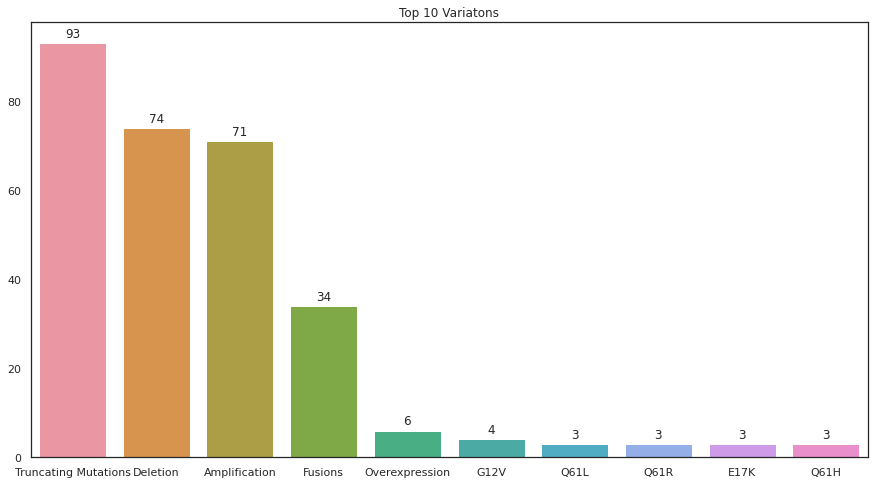

In [17]:
"""Maioria das variações observadas são mutações truncadas"""
dados = top_var[:10]
plt.figure(figsize=(15,8))
sns.set_theme(style="white", palette=sns.color_palette("Spectral"))
ax = sns.barplot(data=dados, x=dados.Variation.to_list(), y=dados.Count.to_list())
ax.bar_label(ax.containers[0], padding=3)
ax.set_title("Top 10 Variatons")

Text(0.5, 1.0, 'Class Distribution')

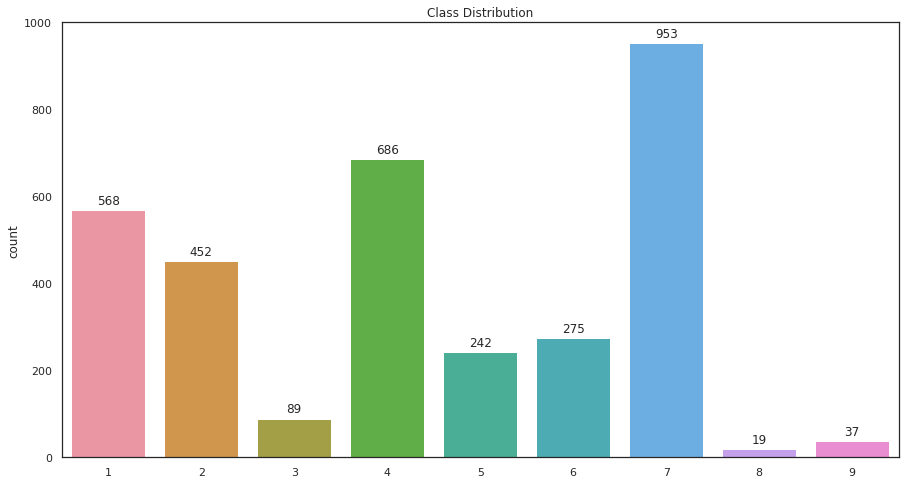

In [18]:
"""
- A classificação predominante é a 7
- As classes 3, 8 e 9 são pouco representadas"""
plt.figure(figsize=(15,8))
sns.set_theme(style="white", palette=sns.color_palette("Spectral"))
ax = sns.countplot(data=train, x=train.Class.to_list())
ax.bar_label(ax.containers[0], padding=3)
ax.set_title("Class Distribution")

In [19]:
# Avaliar a frequência de genes por classe
train_top_gene = train[train["Gene"].isin(top_gene.Gene.to_list())]
pd.crosstab(train_top_gene.Gene, train_top_gene.Class)

Class,1,2,3,4,5,6,7,8,9
Gene,,,,,,,,,
ALK,0,7,10,0,5,0,47,0,0
BRAF,0,31,1,2,8,3,48,0,0
BRCA1,60,0,15,46,90,53,0,0,0
BRCA2,18,0,0,3,20,84,0,0,0
CDKN2A,4,0,0,47,0,1,0,0,0
EGFR,1,45,1,5,3,1,84,1,0
ERBB2,1,14,0,5,6,12,30,1,0
FGFR2,7,7,0,0,5,4,27,0,0
FLT3,1,4,7,0,0,0,37,0,0


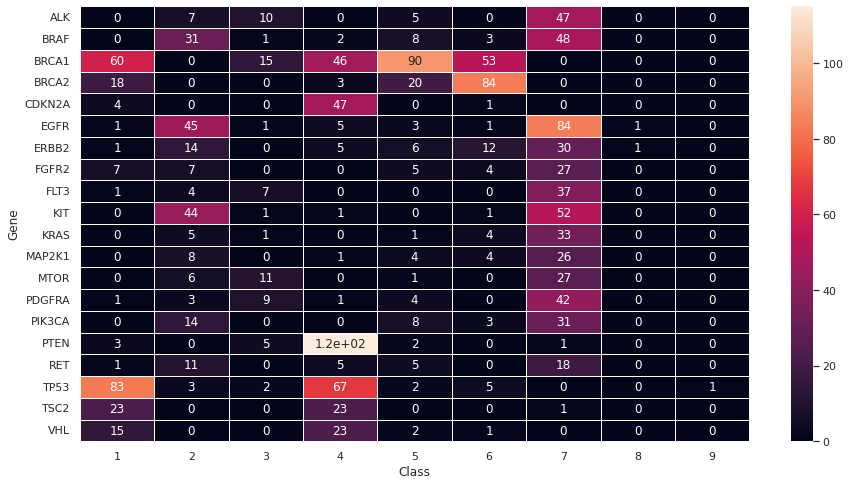

In [20]:
"""
- Alguns genes como PTEN e CDKN2A são mais prevalentes na classe 4
- Outros genes como TP53 sã prevalentes em duas classes (1 w 2)
- As classes 8 e 9 apresentam nenhum genes frequentes
- Muitos genes são frequentes na classe 7
"""
ct = pd.crosstab(train_top_gene.Gene, train_top_gene.Class)
plt.figure(figsize=(15,8))
sns.set_theme(style="white", palette=sns.color_palette("Spectral"))
ax = sns.heatmap(ct, annot=True, linewidths=.5)

In [21]:
# Visualizar o conteúdo do texto
""" Parece que o texto é de um artigo científico publicado """
train["Text"][0]

"Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK1

In [27]:
# Definir função para feature engineering adicionando coluna com o número de caracteres do texto
def add_len(df, col, new_col):
    x = [len(str(r[col])) for i, r in df.iterrows()]
    return df.insert(len(df.columns), new_col, x, True)

In [31]:
# Add coluna com número de caracteres da coluna de texto
add_len(train, "Text", "txt_len")
train

,ID,Gene,Variation,Class,Text,txt_len
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,39672
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,36691
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,36691
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,36238
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,41308
...,...,...,...,...,...,...
3316,3316,RUNX1,D171N,4,Introduction Myelodysplastic syndromes (MDS) ...,73895
3317,3317,RUNX1,A122*,1,Introduction Myelodysplastic syndromes (MDS) ...,40127
3318,3318,RUNX1,Fusions,1,The Runt-related transcription factor 1 gene (...,36200
3319,3319,RUNX1,R80C,4,The RUNX1/AML1 gene is the most frequent targe...,32520


Text(0.5, 1.0, 'Histogram comprimento do texto')

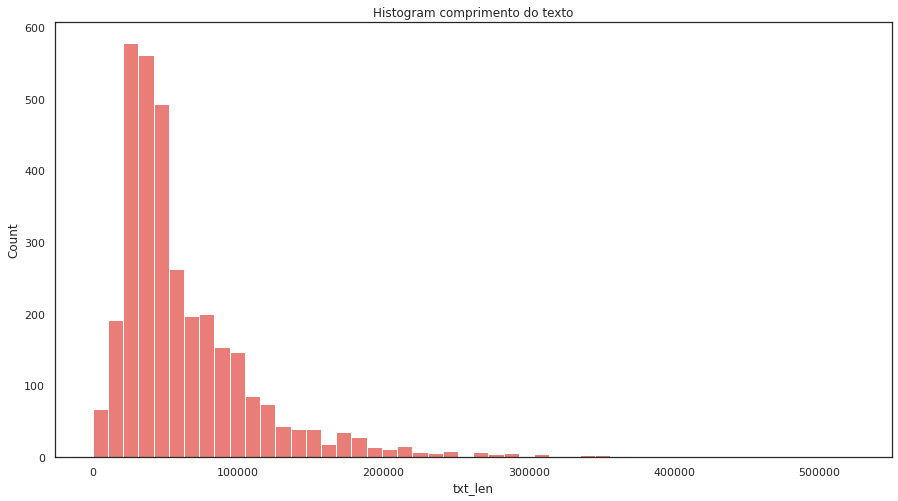

In [32]:
# Visualiar o comprimento dos textos com histograma
plt.figure(figsize=(15,8))
sns.set_theme(style="white", palette=sns.color_palette("Spectral"))
ax = sns.histplot(data=train, x="txt_len", bins=50)
ax.set_title("Histogram comprimento do texto")

<Figure size 1080x576 with 0 Axes>

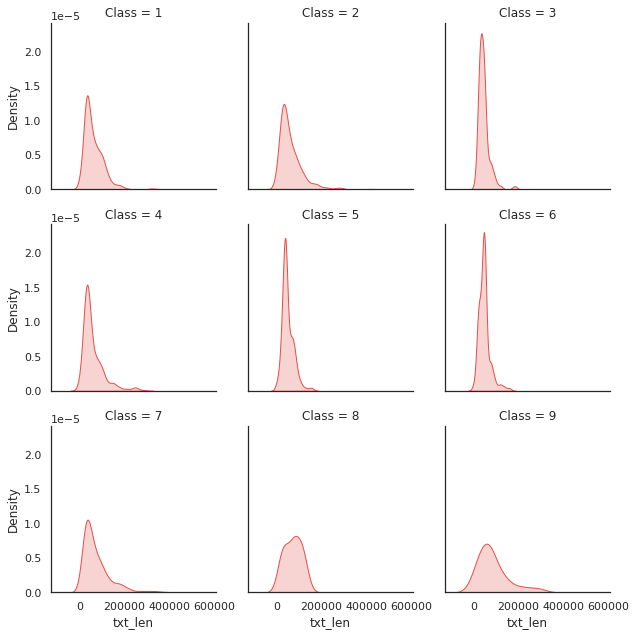

In [33]:
# Visualiar o comprimento do texto com histograma por classe
plt.figure(figsize=(15,8))
sns.set_theme(style="white", palette=sns.color_palette("Spectral"))
g = sns.FacetGrid(train, col="Class", col_wrap=3)
g.map(sns.kdeplot, "txt_len", fill=True)

In [34]:
# Checar a mediana e média dos comprimentos por classe
"""
- Classe 8 e 9 precisa de mais texto
"""
train.groupby("Class")["txt_len"].agg(["mean", "median"])

,mean,median
Class,,
1,62764.943662,49580.5
2,62135.013274,45433.0
3,44917.719101,36899.0
4,59789.788630,42789.0
5,49869.090909,42859.0
6,47676.727273,46287.0
7,76369.902413,54674.0
8,72914.473684,76144.0
9,85792.918919,73431.0


In [35]:
# Observar quais linhas não contém textos no dataset
# Já sabemos que são cinco
train[train.txt_len < 100]

,ID,Gene,Variation,Class,Text,txt_len
1109,1109,FANCA,S1088F,1,NaN,3
1277,1277,ARID5B,Truncating Mutations,1,NaN,3
1407,1407,FGFR3,K508M,6,NaN,3
1639,1639,FLT1,Amplification,6,NaN,3
2755,2755,BRAF,G596C,7,NaN,3


In [41]:
# Definir função para feature engineering e inserir contagem de palavras específicas nos textos
def count_word(df, col, words):
    for word in words:
        x = list(df[col].str.count(word))
        y = "count_"+word
        df.insert(len(df.columns), y, x, True)

In [42]:
words = ["pathogenic", "benign"]
count_word(train, "Text", words)
train

,ID,Gene,Variation,Class,Text,txt_len,count_pathogenic,count_benign
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,39672,0.0,0.0
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,36691,0.0,0.0
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,36691,0.0,0.0
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,36238,1.0,0.0
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,41308,0.0,5.0
...,...,...,...,...,...,...,...,...
3316,3316,RUNX1,D171N,4,Introduction Myelodysplastic syndromes (MDS) ...,73895,0.0,0.0
3317,3317,RUNX1,A122*,1,Introduction Myelodysplastic syndromes (MDS) ...,40127,0.0,0.0
3318,3318,RUNX1,Fusions,1,The Runt-related transcription factor 1 gene (...,36200,0.0,0.0
3319,3319,RUNX1,R80C,4,The RUNX1/AML1 gene is the most frequent targe...,32520,0.0,0.0


<Figure size 1080x576 with 0 Axes>

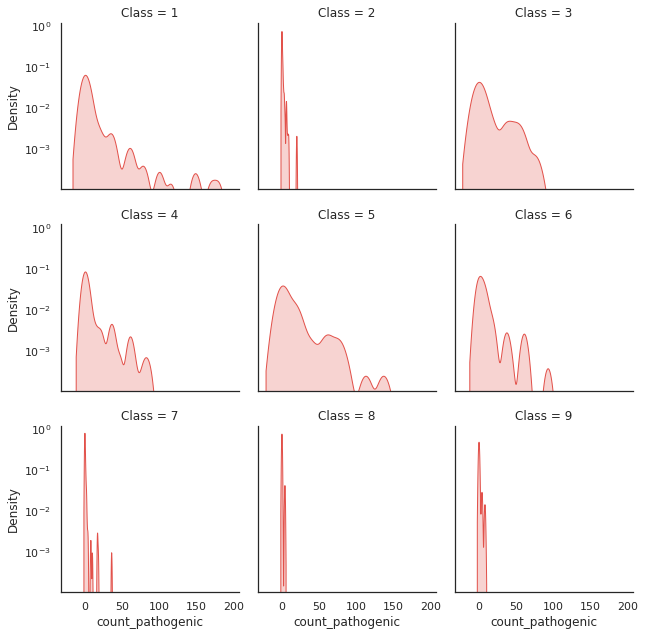

In [44]:
# Visualiar o pathogenic por classe
"""
- A palavra pathogenic é mais frequente nas classes 1, 3, 4, 5 e 6
"""
plt.figure(figsize=(15,8))
sns.set_theme(style="white", palette=sns.color_palette("Spectral"))
g = sns.FacetGrid(train, col="Class", col_wrap=3)
g.map(sns.kdeplot, "count_pathogenic", fill=True)
g.set(yscale="log")

<Figure size 1080x576 with 0 Axes>

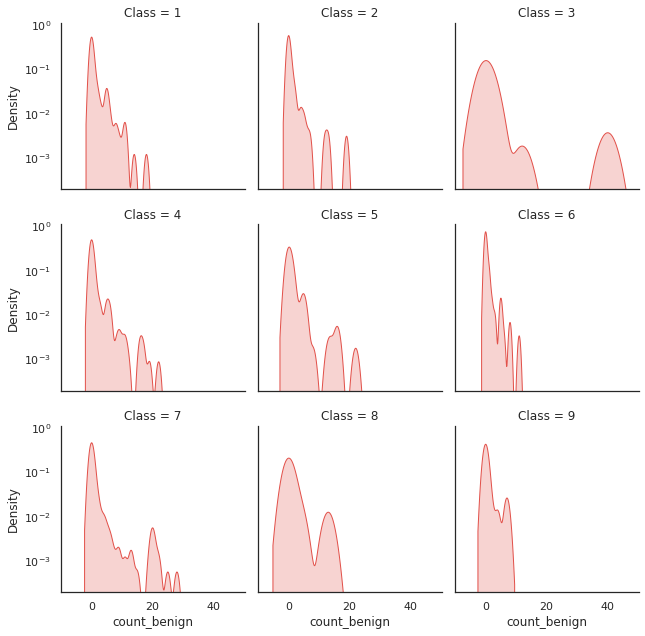

In [45]:
# Visualiar o benign por classe
plt.figure(figsize=(15,8))
sns.set_theme(style="white", palette=sns.color_palette("Spectral"))
g = sns.FacetGrid(train, col="Class", col_wrap=3)
g.map(sns.kdeplot, "count_benign", fill=True)
g.set(yscale="log")

In [47]:
# Verificar a razão de pathogenic por benign no dataset
ratio = train.groupby("Class")["count_benign", "count_pathogenic"].agg("mean").reset_index()
ratio = ratio.assign(path_ben = ratio['count_pathogenic'] / ratio["count_benign"])
ratio = ratio.sort_values("path_ben", ascending=False)
ratio

/tmp/ipykernel_29397/4186029586.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ratio = train.groupby("Class")["count_benign", "count_pathogenic"].agg("mean").reset_index()


,Class,count_benign,count_pathogenic,path_ben
5,6,0.450549,6.681319,14.829268
4,5,1.082645,12.074380,11.152672
2,3,1.191011,9.112360,7.650943
3,4,0.820700,5.960641,7.262877
0,1,0.848057,6.136042,7.235417
1,2,0.584071,0.473451,0.810606
8,9,0.567568,0.459459,0.809524
6,7,0.757353,0.322479,0.425798
7,8,1.000000,0.210526,0.210526


Text(0.5, 1.0, 'Razão de pathigenic / benign')

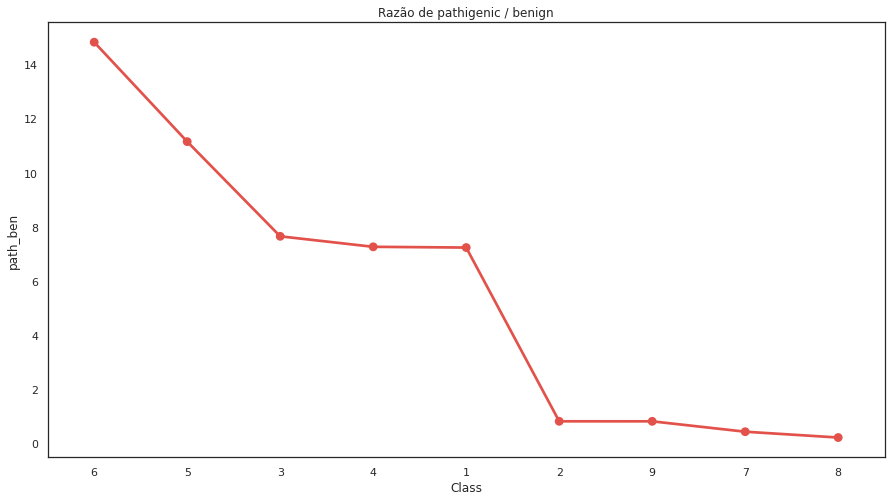

In [48]:
# Visualiar o grafico da razão de pathogenic por benign
"""
- Parece haver uma distinção entre os grupos 2, 7, 8 e 9 vs 1, 3, 4, 5 e 6
"""
plt.figure(figsize=(15,8))
sns.set_theme(style="white", palette=sns.color_palette("Spectral"))
ax = sns.pointplot(data=ratio, x="Class", y="path_ben", order=ratio.Class)
ax.set_title("Razão de pathigenic / benign")

In [49]:
# Definir função para limpar o texto
def cleanUpText(txt):
    txt = re.sub(r"\``", "", str(txt))
    txt = re.sub(r"\-", " ", str(txt))
    txt = re.sub(r"\d", "", str(txt))
    txt = re.sub(r"\,", "", str(txt))
    txt = re.sub(r"\:", "", str(txt))
    txt = re.sub(r"\[", "", str(txt))
    txt = re.sub(r"\]", "", str(txt))
    txt = re.sub(r"\%", "", str(txt))
    txt = re.sub(r"\;", "", str(txt))
    txt = re.sub(r"\.", "", str(txt))
    txt = re.sub(r"\(", "", str(txt))
    txt = re.sub(r"\)", "", str(txt))
    txt = re.sub(r'\$', "", str(txt))
    txt = re.sub(r'\/', "", str(txt))
    txt = re.sub(r'\@', "", str(txt))
    txt = re.sub(r"\b[a-z]\b", "", str(txt))
    return txt

In [50]:
# Aplicar a função de limpar os tweets
train['txt'] = train['Text'].apply(cleanUpText)

In [51]:
# Definir função para separar as palavras em listas
def list_words(df, col, new_col):
    x = [str(x).split() for x in df[col].str.lower()]
    train.insert(len(df.columns), new_col, x, True)

In [52]:
# Separar as frases em palavras separando pelo espaço e incluir no dataset
list_words(train, "txt", "word")
train

,ID,Gene,Variation,Class,Text,txt_len,count_pathogenic,count_benign,txt,word
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,39672,0.0,0.0,Cyclin dependent kinases CDKs regulate variet...,"[cyclin, dependent, kinases, cdks, regulate, v..."
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,36691,0.0,0.0,Abstract Background Non small cell lung canc...,"[abstract, background, non, small, cell, lung,..."
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,36691,0.0,0.0,Abstract Background Non small cell lung canc...,"[abstract, background, non, small, cell, lung,..."
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,36238,1.0,0.0,Recent evidence has demonstrated that acquired...,"[recent, evidence, has, demonstrated, that, ac..."
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,41308,0.0,5.0,Oncogenic mutations in the monomeric Casitas B...,"[oncogenic, mutations, in, the, monomeric, cas..."
...,...,...,...,...,...,...,...,...,...,...
3316,3316,RUNX1,D171N,4,Introduction Myelodysplastic syndromes (MDS) ...,73895,0.0,0.0,Introduction Myelodysplastic syndromes MDS ar...,"[introduction, myelodysplastic, syndromes, mds..."
3317,3317,RUNX1,A122*,1,Introduction Myelodysplastic syndromes (MDS) ...,40127,0.0,0.0,Introduction Myelodysplastic syndromes MDS ar...,"[introduction, myelodysplastic, syndromes, mds..."
3318,3318,RUNX1,Fusions,1,The Runt-related transcription factor 1 gene (...,36200,0.0,0.0,The Runt related transcription factor gene RU...,"[the, runt, related, transcription, factor, ge..."
3319,3319,RUNX1,R80C,4,The RUNX1/AML1 gene is the most frequent targe...,32520,0.0,0.0,The RUNXAML gene is the most frequent target f...,"[the, runxaml, gene, is, the, most, frequent, ..."


In [53]:
# Separar as palavras por linha de acordo com a classe de cada palavra
# Importante caso seja necessário para alguma análise
train_by_word = train[["Class", "word"]]
train_by_word = train_by_word.explode("word")
train_by_word

,Class,word
0,1,cyclin
0,1,dependent
0,1,kinases
0,1,cdks
0,1,regulate
...,...,...
3320,4,be
3320,4,identified
3320,4,by
3320,4,novel


In [54]:
# Importando os stopwords
# Incluindo palavras ao stopwords
stopwords = nltk.corpus.stopwords.words('english')
my_list = ["fig", "figure", "et", "al", "table",
                "data", "analysis", "analyze", "study",
                "method", "result", "conclusion", "author",
                "find", "found", "show", "perform",
                "demonstrate", "evaluate", "discuss", "et"]
stopwords.extend(my_list)
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [55]:
# Criando lista de palavras de todos os textos
words = "" 

# Separando os inisghts em palavras e adicionando na lista 
for i in train["txt"]: 
      
    # Transformando em string 
    i = str(i) 
  
    # Separando as palavras 
    tokens = i.split()
        
    # convertendo em lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
        
     # Adicionando na lista 
    words += " ".join(tokens)+" "

In [56]:
# Avaliando as palavras mais comuns em todos os textos juntos
words_tk = [word for word in nltk.word_tokenize(words) if not word in stopwords]
words_dist = nltk.FreqDist(words_tk)
most_common = pd.DataFrame(words_dist.most_common(20), columns=["most_common", "count"])
most_common

,most_common,count
0,mutations,238034
1,cells,185221
2,cell,125641
3,mutation,105125
4,cancer,99601
5,patients,86534
6,protein,82675
7,expression,77658
8,activity,76819
9,brca,73833


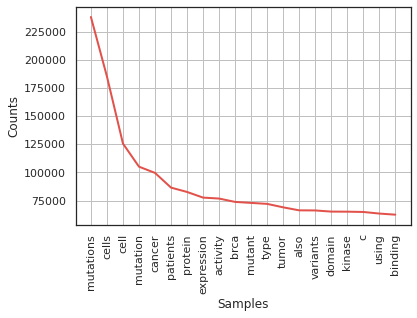

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [57]:
# Plotar gráfico das palavras mais comuns
words_dist.plot(20)

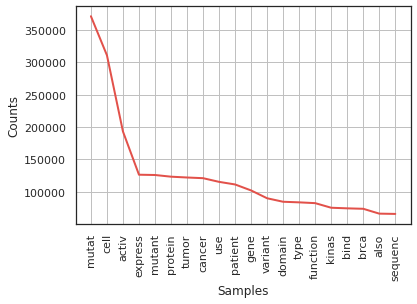

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [58]:
# Plotar gráfico das palavras stemem 
"""
Importante para tirar as palavras com mesmo significado como
mutations e mutation e mutant que passa ser uma só com mutat
"""
words_tk_porter = [nltk.stem.PorterStemmer().stem(word) for word in words_tk]
words_porter_dist = nltk.FreqDist(words_tk_porter)
words_porter_dist.plot(20)

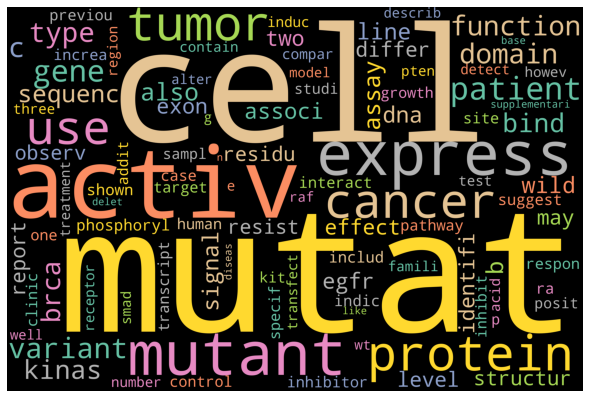

In [59]:
# Plotar wordcloud com as palavras stemem
wordcloud_text = str(words_tk_porter)
wordcloud_text = re.sub("'", '', wordcloud_text)

# Setando a wordcloud por palavras
wordcloud = WordCloud(width = 3000, height = 2000, 
                background_color ='black', 
                collocations=False,
                stopwords=stopwords,
                colormap='Set2',
                max_words = 100,
                min_font_size = 10).generate(wordcloud_text)

# plotando a wordcloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [60]:
# Quais são as duas palavras em sequência mais importantes
words_porter_bigrams = nltk.FreqDist(nltk.bigrams(words_tk_porter))
bigrams = pd.DataFrame(words_porter_bigrams.most_common(20), columns=["bigrams", "count"])
bigrams

,bigrams,count
0,"(wild, type)",56035
1,"(cell, line)",41554
2,"(amino, acid)",26395
3,"(−, −)",19027
4,"(breast, cancer)",14121
5,"(kinas, domain)",13760
6,"(egfr, mutat)",13635
7,"(missens, mutat)",13026
8,"(tyrosin, kinas)",12990
9,"(cell, express)",12730


Text(0.5, 1.0, 'Top 20 Bigrams')

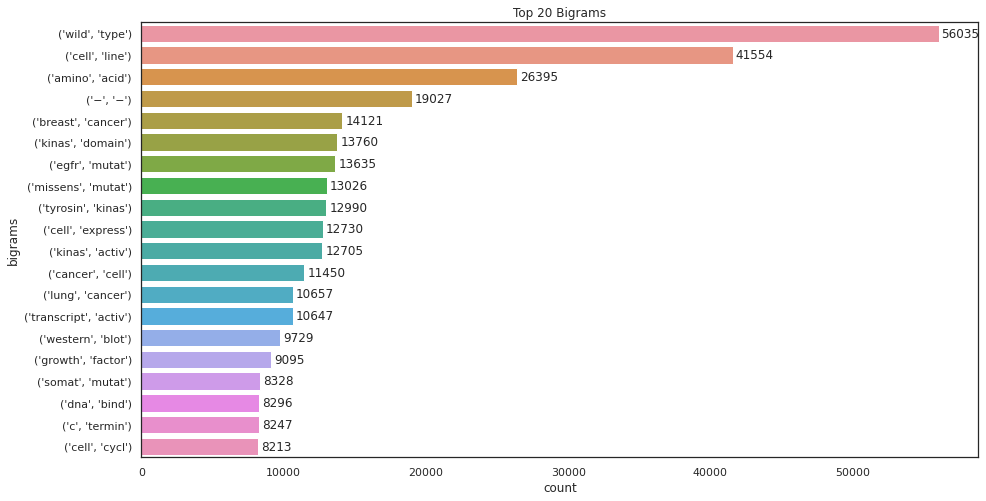

In [61]:
# Gráfico das dias palavras mais imporantes
plt.figure(figsize=(15,8))
sns.set_theme(style="white", palette=sns.color_palette("Spectral"))
ax = sns.barplot(data=bigrams, x="count", y="bigrams", orient="h")
ax.bar_label(ax.containers[0], padding=3)
ax.set_title("Top 20 Bigrams")

In [62]:
# Quais são as três palavras mais imporantes
words_porter_trigrams = nltk.FreqDist(nltk.trigrams(words_tk_porter))
trigrams = pd.DataFrame(words_porter_trigrams.most_common(20), columns=["trigrams", "count"])
trigrams 

,trigrams,count
0,"(−, −, −)",9771
1,"(cancer, cell, line)",4900
2,"(amino, acid, substitut)",4835
3,"(wild, type, mutant)",4598
4,"(growth, factor, receptor)",3717
5,"(nih, pa, manuscript)",3399
6,"(*, *, *)",3368
7,"(compar, wild, type)",3350
8,"(express, wild, type)",3151
9,"(cell, lung, cancer)",3087


Text(0.5, 1.0, 'Top 20 Trigrams')

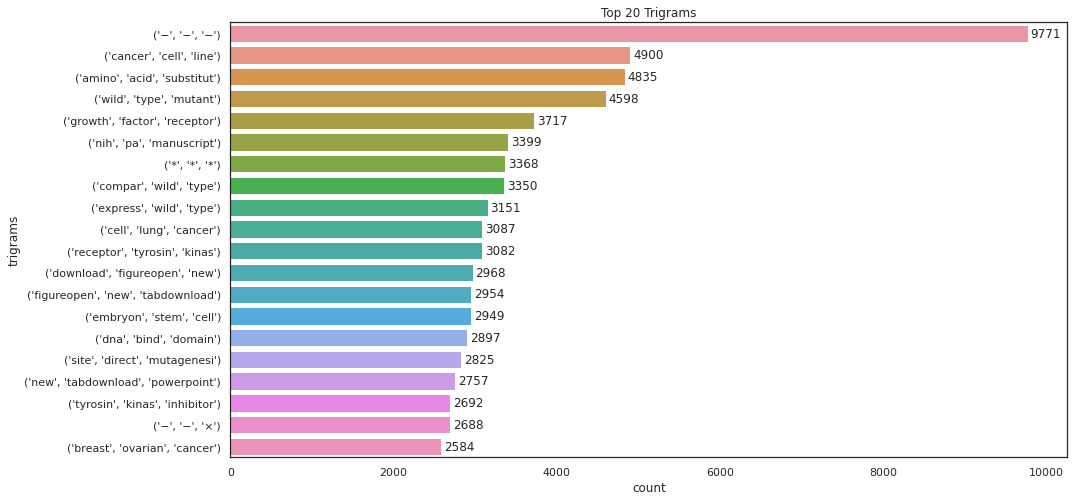

In [63]:
# Gráfico das 3 palavras mais imporantes
plt.figure(figsize=(15,8))
sns.set_theme(style="white", palette=sns.color_palette("Spectral"))
ax = sns.barplot(data=trigrams, x="count", y="trigrams", orient="h")
ax.bar_label(ax.containers[0], padding=3)
ax.set_title("Top 20 Trigrams")

In [64]:
# Preparar dados para criar uma network com os bigramas mais comuns
bigrams_nx = pd.DataFrame(words_porter_bigrams.most_common(50), columns=["bigrams", "count"])

# Create dictionary of bigrams and their counts
d = bigrams_nx.set_index('bigrams').T.to_dict('records')

In [65]:
# Criar o gráfico de network 
G = nx.Graph()

# Criar as conexões do gráfico
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v))

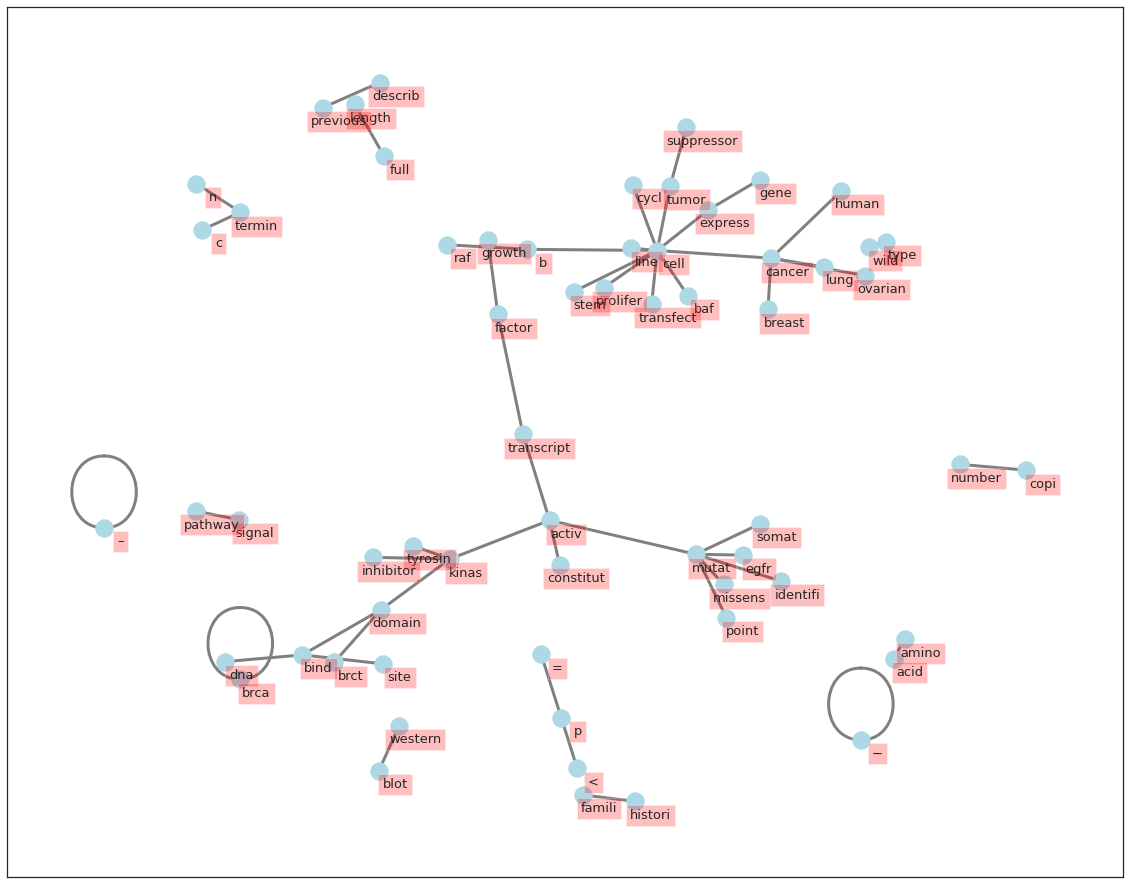

In [66]:
# Plotar o gráfico
fig, ax = plt.subplots(figsize=(20, 16))

pos = nx.spring_layout(G, k=5)
nx.draw_networkx(G, pos,
                font_size=16,
                width=3,
                edge_color='grey',
                node_color='lightblue',
                with_labels = False,
                ax=ax)

# Adicionar os labels
for key, value in pos.items():
    x, y = value[0]+.035, value[1]-.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

**<h1>Loading data for keras</h1>**

In [81]:
# Load datasets de novo
train = pd.merge(df_var, df_txt, how='left', on='ID')
test_x = pd.merge(test_var, test_txt, how='left', on='ID')

In [82]:
# Add feature engeniring no dataset de treino
add_len(train, "Text", "txt_len")
count_word(train, "Text", ["pathogenic", "benign"])
train

,ID,Gene,Variation,Class,Text,txt_len,count_pathogenic,count_benign
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,39672,0.0,0.0
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,36691,0.0,0.0
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,36691,0.0,0.0
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,36238,1.0,0.0
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,41308,0.0,5.0
...,...,...,...,...,...,...,...,...
3316,3316,RUNX1,D171N,4,Introduction Myelodysplastic syndromes (MDS) ...,73895,0.0,0.0
3317,3317,RUNX1,A122*,1,Introduction Myelodysplastic syndromes (MDS) ...,40127,0.0,0.0
3318,3318,RUNX1,Fusions,1,The Runt-related transcription factor 1 gene (...,36200,0.0,0.0
3319,3319,RUNX1,R80C,4,The RUNX1/AML1 gene is the most frequent targe...,32520,0.0,0.0


In [84]:
# Add feature engeniring no dataset de test
add_len(test_x, "Text", "txt_len")
count_word(test_x, "Text", ["pathogenic", "benign"])
test_x

,ID,Gene,Variation,Text,txt_len,count_pathogenic,count_benign
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...,49829,0.0,0.0
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...,31326,1.0,0.0
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...,75282,0.0,0.0
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...,53996,1.0,0.0
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...,76967,1.0,0.0
...,...,...,...,...,...,...,...
5663,5663,SLC46A1,R113S,The realization in the late 1970s that RAS har...,76385,2.0,0.0
5664,5664,FOXC1,L130F,Hemizygous deletions are common molecular abno...,27014,1.0,0.0
5665,5665,GSS,R267W,All most R267W of has with to SMARTpool invest...,23101,0.0,0.0
5666,5666,CTSK,G79E,Abstract Blood samples from 125 unrelated fami...,67269,1.0,0.0


In [87]:
# Pegar uma amostra dos dados pois o notebook não rodou todos os dados
train = train.sample(frac = 0.5)
test_x = test_x.sample(frac = 0.5)

In [88]:
# Separar a variável dependente do dataset de treino, salvar os id e excluir o id
# Salvar o id e excluir o id do dataset de test
train_y = train["Class"].values
train_id = train["ID"].values
train_x = train.drop(["Class", "ID"], axis=1)
train_size = len(train_x)
test_size = len(test_x)
test_id = test_x["ID"].values
test_x = test_x.drop("ID", axis=1)

In [91]:
# Contatenar os datasets de treino e test
all_data = np.concatenate((train_x, test_x), axis=0)
all_data = pd.DataFrame(all_data)
all_data.columns = ["Gene", "Variation", "Text", "txt_len", "count_pathogenic", "count_benign"]
all_data

,Gene,Variation,Text,txt_len,count_pathogenic,count_benign
0,EP300,EP300-MLL Fusion,The p300 protein shows a striking homology wit...,95475,0.0,0.0
1,SMAD4,V370D,The Smad4/DPC4 tumour suppressor1 is inactivat...,181560,0.0,0.0
2,CDKN1B,P133T,Context: Typical nonfamilial (sporadic) parat...,14698,1.0,2.0
3,JAK1,Y652H,T-cell acute lymphoblastic leukemia (T-ALL) is...,29685,0.0,0.0
4,BRCA1,E1735K,Abstract The BRCA1 gene from individuals at ...,70597,18.0,6.0
...,...,...,...,...,...,...
2242,SYNE1,E8413K,A considerable number of patients with metasta...,28332,14.0,0.0
2243,CASP10,A414V,Abstract Ras GTPases function as binary swit...,74756,20.0,0.0
2244,EFEMP2,E57K,Terminal deletions of chromosome 10p result in...,42696,0.0,0.0
2245,MED12,N1007S,The CCAAT/enhancer binding protein α (C/EBPα) ...,46457,0.0,0.0


**Pré processamento dos dados**

In [92]:
def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", str(text))
    text = text.lower().split()
    text = [w for w in text if not w in stopwords]    
    text = " ".join(text)
    return(text)
    
def cleanup(text):
    text = textClean(text)
    text= text.translate(str.maketrans("","", string.punctuation))
    return text

In [93]:
allText = all_data['Text'].apply(cleanup)
allText.head()

0    p300 protein shows striking homology cyclicamp...
1    smad4dpc4 tumour suppressor1 inactivated nearl...
2    context typical nonfamilial sporadic parathyro...
3    tcell acute lymphoblastic leukemia tall aggres...
4    abstract brca1 gene individuals risk breast ov...
Name: Text, dtype: object

In [94]:
def constructLabeledSentences(data):
    sentences=[]
    for index, row in data.items():
        sentences.append(TaggedDocument(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

In [95]:
sentences = constructLabeledSentences(allText)
sentences[0]

TaggedDocument(words=['p300', 'protein', 'shows', 'striking', 'homology', 'cyclicampresponseelementbindingprotein', 'binding', 'protein', 'cbp', 'proteins', 'form', 'family', 'dnabinding', 'transcriptional', 'coactivatorshistone', 'acetyltransferases', 'authors', 'herein', 'report', 'therapyrelated', 'acute', 'myeloid', 'leukemia', 'mllp300', 'fusion', 'gene', 'spectral', 'karyotyping', 'clarified', 'chromosome', '11', 'involved', 'complex', '12211', 'q44q13q23', 'fused', 'chromosome', '22', 'direct', 'sequencing', 'revealed', 'fusion', 'exon', '8', 'mll', 'exon', '15', 'p300', 'case', 'second', 'reported', 'case', 'leukemia', 'mllp300', 'fusion', 'gene', 'case', 'mllp300', 'also', 'therapyrelated', 'leukemia', 'considering', 'mllcbp', 'fusion', 'gene', 'also', 'almost', 'exclusively', 'therapyrelated', 'leukemia', 'association', 'mllp300', 'mllcbp', 'therapyrelated', 'leukemia', 'rather', 'de', 'novo', 'leukemia', 'thereby', 'suggested', '11q23', 'translocations', 'frequent', 'hematol

**Preparo dos Dados e Features Extraction**

Text Featurizer using Doc2Vec

In [97]:
# Treinar Doc2Vec nos dados de texto e transformar em números
Text_INPUT_DIM = 300
text_model = Doc2Vec(min_count=1, window=5, vector_size=Text_INPUT_DIM, sample=1e-4, negative=5, workers=4, epochs=5,seed=1)
text_model.build_vocab(sentences)
text_model.train(sentences, total_examples=text_model.corpus_count, epochs=text_model.epochs)

In [98]:
# Featurize text for your training and testing dataset
text_train_arrays = np.zeros((train_size, Text_INPUT_DIM))
text_test_arrays = np.zeros((test_size, Text_INPUT_DIM))

for i in range(train_size):
    text_train_arrays[i] = text_model.docvecs['Text_'+str(i)]

j = 0
for i in range(train_size,train_size+test_size):
    text_test_arrays[j] = text_model.docvecs['Text_'+str(i)]
    j=j+1
    
print(text_train_arrays[0][:50])

[-0.3399646   0.27787012  0.69908398  0.96516097 -0.21632101 -0.01218581
 -0.42239964  0.92082071 -0.30718338 -0.43256003  1.23147297  0.39136934
 -1.0315721   0.95049447  0.32430717 -2.50092864  0.72165602 -0.00994975
  0.98565263  0.07740054 -1.5181421   0.34948039  0.38930103  0.48070014
  0.81121546 -0.43810835 -0.89952129  0.12329262 -0.07073541  0.10279391
  0.11179417  1.05974531 -1.41326523 -0.15151648 -0.37723497 -0.19642486
  0.08514746  0.0550555   0.20893246  1.13174057  0.19985402 -0.18345688
  0.97186017  0.27474162  0.08767118 -0.899652    0.66185939  0.09847122
  0.50584275  0.26256946]


/tmp/ipykernel_29397/90718875.py:6: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  text_train_arrays[i] = text_model.docvecs['Text_'+str(i)]
/tmp/ipykernel_29397/90718875.py:10: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  text_test_arrays[j] = text_model.docvecs['Text_'+str(i)]


**Featurize as colunas Gene e Variation**

In [99]:
# Transformar as colunas gene e variation que são categóricas em variáveis dummies
# Usar svd para reduzir a dimensionalidade pois muitas colunas serão criadas
Gene_INPUT_DIM = 25

svd = TruncatedSVD(n_components=25, n_iter=Gene_INPUT_DIM)

one_hot_gene = pd.get_dummies(all_data['Gene'])
truncated_one_hot_gene = svd.fit_transform(one_hot_gene.values)

one_hot_variation = pd.get_dummies(all_data['Variation'])
truncated_one_hot_variation = svd.fit_transform(one_hot_variation.values)

**Padronizar as colunas txt_len, count_pathogenic e count_benign**

In [171]:
var_scaler = StandardScaler().fit_transform(all_data[["txt_len"]].values)
# var_scaler = MinMaxScaler().fit_transform(all_data[["txt_len"]])
var_scaler[0]

array([0.98268731])

**Transformar os labels da variável dependente em 0 ou número de classes -1**

In [172]:
label_encoder = LabelEncoder()
label_encoder.fit(train_y)
encoded_y = np_utils.to_categorical((label_encoder.transform(train_y)))
print(encoded_y[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0.]


**Juntar as features transformadas**

In [173]:
train_set = np.hstack((truncated_one_hot_gene[:train_size],truncated_one_hot_variation[:train_size],var_scaler[:train_size],text_train_arrays))
test_set = np.hstack((truncated_one_hot_gene[train_size:],truncated_one_hot_variation[train_size:],var_scaler[train_size:],text_test_arrays))
print(train_set[0][:50])

[ 2.10506907e-28 -7.16066410e-22 -1.19946717e-19 -1.84171651e-19
  2.35977716e-18  3.62637380e-19 -1.30794246e-18  8.43007711e-20
 -3.24247737e-18  3.82709980e-19  1.55102902e-21 -3.16154268e-21
  1.43620291e-21  3.22400552e-20 -2.35574185e-20 -5.61191250e-21
  2.03073513e-21  1.78331974e-21 -4.86002220e-21  1.68711588e-20
 -3.63765783e-21  9.79647151e-21 -1.60002768e-19  8.08632672e-19
  5.80221427e-19  2.57956461e-19 -1.11055494e-19 -1.49615528e-19
 -1.03512470e-21  7.28146493e-15  1.02150590e-09  2.51558937e-10
  2.00423506e-09 -4.40275032e-03 -5.54285354e-03 -1.33010412e-02
  4.81864721e-03  4.67540437e-03  1.81134537e-02 -2.25351592e-02
  2.97360245e-03 -3.81284167e-02  1.80713393e-02 -1.08663382e-03
  8.93708817e-04 -1.80759152e-02 -4.41063711e-02 -1.14629071e-02
 -3.07976900e-03 -2.73053367e-02]


**Treinar o modelo**

In [174]:
# Definir o modelo
def baseline_model():
    model = Sequential()
    model.add(Dense(256, input_dim=1+Text_INPUT_DIM+Gene_INPUT_DIM*2, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(80, kernel_initializer='normal', activation='relu'))
    model.add(Dense(9, kernel_initializer='normal', activation="softmax"))
    
    sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
    model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics=['accuracy'])
    return model

model = baseline_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 256)               90112     
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 80)                20560     
_________________________________________________________________
dense_31 (Dense)             (None, 9)                 729       
Total params: 177,193
Trainable params: 177,193
Non-trainable params: 0
________________________________________________

In [175]:
# Treinar o modelo
estimator = model.fit(train_set, encoded_y, validation_split=0.2, epochs=1000, batch_size=64)

Epoch 1/1000
11/11 [==============================] - 1s 28ms/step - loss: 2.2027 - accuracy: 0.0979 - val_loss: 2.1736 - val_accuracy: 0.1265
Epoch 2/1000
11/11 [==============================] - 0s 4ms/step - loss: 2.1668 - accuracy: 0.1169 - val_loss: 2.1430 - val_accuracy: 0.2711
Epoch 3/1000
11/11 [==============================] - 0s 5ms/step - loss: 2.1561 - accuracy: 0.1911 - val_loss: 2.1133 - val_accuracy: 0.3012
Epoch 4/1000
11/11 [==============================] - 0s 6ms/step - loss: 2.1105 - accuracy: 0.2523 - val_loss: 2.0815 - val_accuracy: 0.3072
Epoch 5/1000
11/11 [==============================] - 0s 5ms/step - loss: 2.0741 - accuracy: 0.2876 - val_loss: 2.0495 - val_accuracy: 0.3072
Epoch 6/1000
11/11 [==============================] - 0s 5ms/step - loss: 2.0507 - accuracy: 0.2756 - val_loss: 2.0153 - val_accuracy: 0.3072
Epoch 7/1000
11/11 [==============================] - 0s 5ms/step - loss: 2.0177 - accuracy: 0.2717 - val_loss: 1.9812 - val_accuracy: 0.3072
Epoch

In [176]:
# Imprimir o valor da acurácia no treino e validação
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % (100*estimator.history['accuracy'][-1], 100*estimator.history['val_accuracy'][-1]))

Training accuracy: 98.04% / Validation accuracy: 56.63%


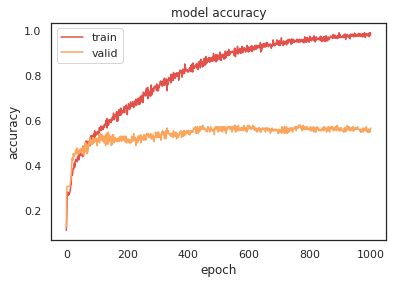

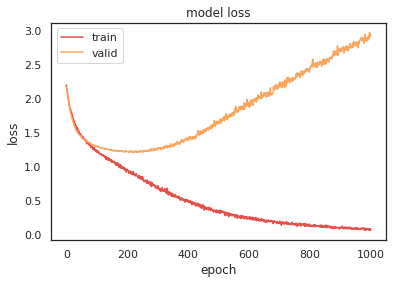

In [177]:
# Plotar gráfico de acurácia e loss
plt.plot(estimator.history['accuracy'])
plt.plot(estimator.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [178]:
# Predict
y_pred = model.predict(test_set)

In [186]:
# Submission file
submission = pd.DataFrame(y_pred)
submission['id'] = test_id
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'id']
submission.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9,id
0,1.542467e-08,2.123961e-02,2.109124e-07,1.544954e-09,6.270668e-07,9.930558e-09,9.787591e-01,6.363611e-07,3.765614e-09,2587
1,8.302263e-01,6.764712e-07,1.842022e-07,1.691656e-01,4.836030e-04,1.234080e-04,7.688470e-11,1.013694e-07,1.543630e-07,3275
2,5.046994e-01,2.830629e-01,1.137821e-03,1.324316e-04,1.242850e-02,6.103408e-04,1.959482e-01,1.897539e-03,8.284394e-05,3498
3,9.070242e-01,7.238851e-05,3.976506e-03,6.360634e-02,8.413090e-04,1.843756e-02,2.535345e-04,2.796114e-03,2.992104e-03,1805
4,1.426680e-05,6.831059e-03,8.628143e-06,3.583893e-09,1.213559e-05,1.174799e-07,9.931109e-01,2.273621e-05,2.586529e-07,30


In [187]:
for col in submission.columns:
    submission[col] = submission[col].map('{:.2f}'.format)
submission

,class1,class2,class3,class4,class5,class6,class7,class8,class9,id
0,0.00,0.02,0.00,0.00,0.00,0.00,0.98,0.00,0.00,2587.00
1,0.83,0.00,0.00,0.17,0.00,0.00,0.00,0.00,0.00,3275.00
2,0.50,0.28,0.00,0.00,0.01,0.00,0.20,0.00,0.00,3498.00
3,0.91,0.00,0.00,0.06,0.00,0.02,0.00,0.00,0.00,1805.00
4,0.00,0.01,0.00,0.00,0.00,0.00,0.99,0.00,0.00,30.00
...,...,...,...,...,...,...,...,...,...,...
1412,0.36,0.08,0.00,0.15,0.02,0.38,0.00,0.00,0.00,2843.00
1413,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,299.00
1414,0.18,0.27,0.01,0.00,0.01,0.45,0.02,0.05,0.01,3817.00
1415,0.00,0.01,0.00,0.03,0.00,0.00,0.96,0.00,0.00,1726.00
